<a href="https://colab.research.google.com/github/jinzus/miscellaneous/blob/main/GAUSSIAN_MIXTURES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Gaussian Mixture Models are State-of-the-art in clustering algorithms. Let's implement the algorithm from scratch! 

In [1]:
 # Import dependencies

from urllib import request
from imageio import imread
from math import pi
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from imageio import imread
import tensorflow.image as tfimg
from matplotlib.colors import LogNorm
import cv2
%matplotlib inline

Text(0.5, 1.0, 'Scatter plot')

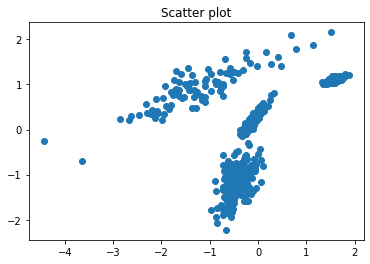

In [2]:
# Make the dataset

def generate_dataset(n_samples_1,n_samples_2,n_samples_3,n_samples_4):
  np.random.seed(15)
  X1,_= make_blobs(n_samples=n_samples_1, centers=np.random.rand(1,2),cluster_std=.9, random_state=21)
  X1 = X1.dot(np.random.rand(2,2))

  np.random.seed(19)
  X2,_= make_blobs(n_samples=n_samples_2, centers=np.random.randint(1,2),cluster_std=1.4, random_state=22)
  X2 = X2.dot(np.random.rand(2,2))

  np.random.seed(13)
  X3,_= make_blobs(n_samples=n_samples_3, centers=np.random.randint(1,2),cluster_std=1.7, random_state=19)
  X3 = X3.dot(np.random.rand(2,2))

  np.random.seed(58)
  X4,_= make_blobs(n_samples=n_samples_4, centers=np.random.randint(1,2),cluster_std=.3, random_state=25)
  X4 = X4.dot(np.random.rand(2,2))

  return StandardScaler().fit_transform(np.concatenate((X1,X2,X3,X4),axis=0))


dataset=generate_dataset(170,250,90,150)
plt.scatter(dataset[:,0],dataset[:,1])
plt.title("Scatter plot",fontsize=12)


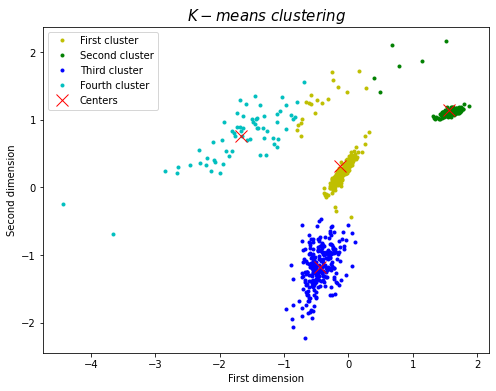

In [3]:
# How sklearn KMeans performs the task

kmus=KMeans(n_clusters=4,random_state=45)
y=kmus.fit_predict(dataset)

plt.figure(figsize=(8,6))
plt.plot(dataset[:,0][y==0],dataset[:,1][y==0],"y.",label="First cluster")
plt.plot(dataset[:,0][y==1],dataset[:,1][y==1],"g.",label="Second cluster")
plt.plot(dataset[:,0][y==2],dataset[:,1][y==2],"b.",label="Third cluster")
plt.plot(dataset[:,0][y==3],dataset[:,1][y==3],"c.",label="Fourth cluster")
plt.plot(kmus.cluster_centers_[:,0],kmus.cluster_centers_[:,1],"xr",markersize=12,label="Centers")
plt.title("$K-means$ $clustering$",fontsize=15)
plt.xlabel("First dimension",fontsize=10)
plt.ylabel("Second dimension",fontsize=10)
plt.legend(loc="upper left")

# This is a terrible result! Instances of the most dispersed cluster have been clearly assigned to the wrong cluster and centroid 
# positions are not convincing at all. KMeans is a bad choice in this case

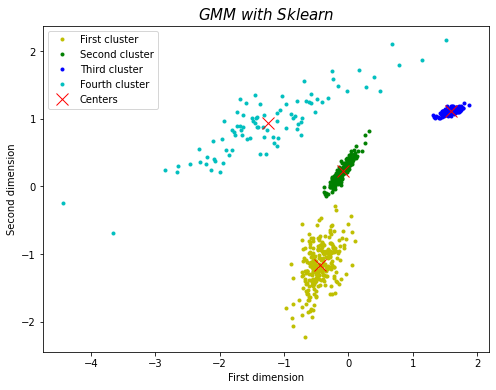

In [4]:
# Let's see how sklearn GMM performs the task

gmm=GaussianMixture(n_components=4,n_init=5,random_state=78)
lab=gmm.fit_predict(dataset)

plt.figure(figsize=(8,6))
plt.plot(dataset[:,0][lab==0],dataset[:,1][lab==0],"y.",label="First cluster")
plt.plot(dataset[:,0][lab==1],dataset[:,1][lab==1],"g.",label="Second cluster")
plt.plot(dataset[:,0][lab==2],dataset[:,1][lab==2],"b.",label="Third cluster")
plt.plot(dataset[:,0][lab==3],dataset[:,1][lab==3],"c.",label="Fourth cluster")
plt.plot(gmm.means_[:,0],gmm.means_[:,1],"xr",markersize=12,label="Centers")
plt.title("$GMM$ $with$ $Sklearn$",fontsize=15)
plt.xlabel("First dimension",fontsize=10)
plt.ylabel("Second dimension",fontsize=10)
plt.legend(loc="upper left")

# Here we go!

Now we create a basic version of the algorithm and then we wrap everything into a more complete class.

In [5]:
# Initialize weights
w=np.ones(4)/4

# Initialize means
mus=np.zeros((4,2))

# Initialize covariances
np.random.seed(13)
var_covs=np.random.rand(16).reshape(2,-1)

# Expectation
def expectation(data,means,covars,weights,eps=1e-8):
  lks=np.empty((len(data),4))
  for row,item in enumerate(data):
    for col,cov_idx in enumerate(range(0,8,2)):
      # the pseudo-determinant is equal to the product of non-zero eigenvalues
      eigens=np.linalg.eig(covars[:,cov_idx:cov_idx+2])[0]
      deter=np.prod(eigens[eigens>eps])
      lk=np.exp(-.5*(item-means[col]).T.dot(np.linalg.inv(covars[:,cov_idx:cov_idx+2]).dot(item-means[col])))/np.sqrt(((2*pi)**2)*deter)
      lks[row,col]=lk
  w_lk=weights*lks
  resp=w_lk/w_lk.sum(axis=-1)[:,np.newaxis]
  log_lik=np.log(w_lk.sum(axis=-1)).sum()
  return resp,log_lik

# Maximization
def maximization(data,resps):
  s_counter=np.sum(resps,axis=0)
  new_means=np.empty((4,2))
  new_covs=np.empty((2,8))
  for ind,comp in enumerate(range(0,8,2)):
    new_means[ind]=(1/s_counter[ind])*np.sum(resps[:,ind][:,np.newaxis]*data,axis=0)
    new_covs[:,comp:comp+2]=(1/s_counter[ind])*np.dot((resps[:,ind][:,np.newaxis]*(data-new_means[ind])).T,(data-new_means[ind]))
  new_weights=s_counter/s_counter.sum()
  return new_weights,new_means,new_covs


In [6]:
early_stop=50
n_iter=100
log_likelihoods=[]
bound=-float("inf")
count=0
for t in range(n_iter):
  responsibilities,log_like=expectation(dataset,mus,var_covs,w)
  w,mus,var_covs=maximization(dataset,responsibilities)
  log_likelihoods.append(log_like)
  if log_like>bound:
    bound=log_like
    count=0
  else:
    count+=1
    if count==early_stop:
      print("Convergence in {:d} iterations".format(t+1))
      break


Convergence in 77 iterations


In [7]:
# Create a function to generate new samples

x_max=2.1
x_min=-4.5
y_max=2.2
y_min=-2.2
def sample_generator(n_samples=10000,x_m=x_min,x_M=x_max,y_m=y_min,y_M=y_max):
  x_vec=np.random.rand(n_samples)
  y_vec=np.random.rand(n_samples)
  x_samples=x_m+(x_vec-x_vec.min())*(x_M-x_m)/(x_vec.max()-x_vec.min())
  y_samples=y_m+(y_vec-y_vec.min())*(y_M-y_m)/(y_vec.max()-y_vec.min())
  return np.c_[x_samples,y_samples]

# Create a function to  perform hard cluster assignments

def hard_clustering(resp):
  tot_lab=[]
  for item in resp:
    lab=np.argmax(item,axis=-1)
    tot_lab.append(lab)
  return np.array(tot_lab)

In [8]:
# Lest's sample a lot of new instances showing them as big squares to cover each possible cluster
# location in the feature space

np.random.seed(17)
data=sample_generator()
eps=1e-5
lks=np.empty((len(data),4))
for row,item in enumerate(data):
  for col,cov_idx in enumerate(range(0,8,2)):
        eigens=np.linalg.eig(var_covs[:,cov_idx:cov_idx+2])[0]
        deter=np.prod(eigens[eigens>eps])
        lk=np.exp(-.5*(item-mus[col]).T.dot(np.linalg.inv(var_covs[:,cov_idx:cov_idx+2]).dot(item-mus[col])))/np.sqrt(((2*pi)**2)*deter)
        lks[row,col]=lk
w_lk=w*lks
resp=w_lk/w_lk.sum(axis=-1)[:,np.newaxis]


Text(0, 0.5, 'loglikelihood')

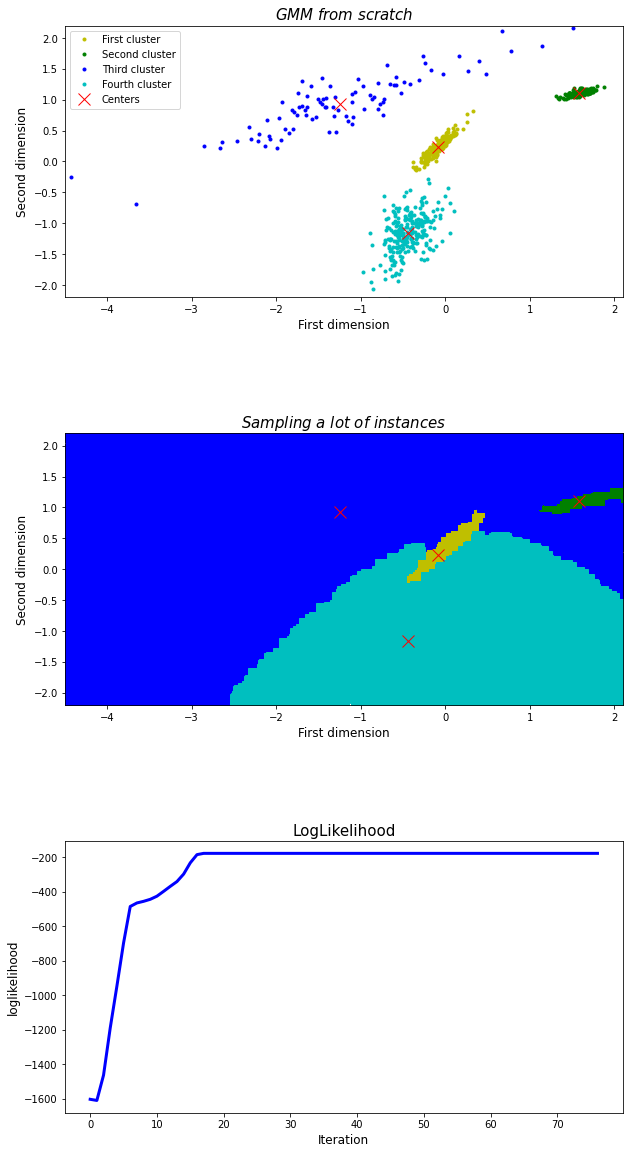

In [15]:
hard_cl=hard_clustering(responsibilities)
plt.figure(figsize=(10,20))
plt.subplots_adjust(wspace=.5,hspace=.5)
plt.subplot(311)
plt.plot(dataset[:,0][hard_cl==0],dataset[:,1][hard_cl==0],"y.",label="First cluster")
plt.plot(dataset[:,0][hard_cl==1],dataset[:,1][hard_cl==1],"g.",label="Second cluster")
plt.plot(dataset[:,0][hard_cl==2],dataset[:,1][hard_cl==2],"b.",label="Third cluster")
plt.plot(dataset[:,0][hard_cl==3],dataset[:,1][hard_cl==3],"c.",label="Fourth cluster")
for ind,item in enumerate(mus):
  if ind==len(mus)-1:
    plt.plot(item[0],item[1],"rx",markersize=12,label="Centers")
  else:
    plt.plot(item[0],item[1],"rx",markersize=12)
plt.title("$GMM$ $from$ $scratch$",fontsize=15)
plt.xlabel("First dimension",fontsize=12)
plt.ylabel("Second dimension",fontsize=12)
plt.legend(loc="upper left")
plt.axis([x_min,x_max,y_min,y_max])

# New instances
preds=hard_clustering(resp)
plt.subplot(312)
plt.plot(data[:,0][preds==0],data[:,1][preds==0],"ys",markersize=12)
plt.plot(data[:,0][preds==1],data[:,1][preds==1],"gs",markersize=12)
plt.plot(data[:,0][preds==2],data[:,1][preds==2],"bs",markersize=12)
plt.plot(data[:,0][preds==3],data[:,1][preds==3],"cs",markersize=12)
for item in mus:
    plt.plot(item[0],item[1],"rx",markersize=12)

plt.title("$Sampling$ $a$ $lot$ $of$ $instances$",fontsize=15)
plt.xlabel("First dimension",fontsize=12)
plt.ylabel("Second dimension",fontsize=12)
plt.axis([x_min,x_max,y_min,y_max])

# LogLikelihood
plt.subplot(313)
plt.plot(log_likelihoods,"b",linewidth=3)
plt.title("LogLikelihood",fontsize=15)
plt.xlabel("Iteration",fontsize=12)
plt.ylabel("loglikelihood",fontsize=12)




In [18]:
# Let's wrap everything into a class and add some extra features

class GMM:
  def __init__(self,data,max_iter=200,early_stop=50,eps=1e-8,n_clusters=4,n_init=5):
    self.data=data
    self.max_iter=max_iter
    self.eps=eps
    self.n_clusters=n_clusters
    self.early_stop=early_stop
    self.n_init=n_init
    self.set_seeds=[]
    for item in range(n_init):
      self.set_seeds.append(item)
  def train(self):
    def random_init(current_seed):
      np.random.seed(current_seed)
      w=np.ones(self.n_clusters)/self.n_clusters
      mus=np.zeros((self.n_clusters,self.data.shape[1]))
      var_covs=np.random.rand(self.data.shape[1],self.data.shape[1]*self.n_clusters)
      return w,mus,var_covs
    def expectation():
      lks=np.empty((len(self.data),self.n_clusters))
      for row,item in enumerate(self.data):
        for col,cov_idx in enumerate(range(0,self.var_covs.shape[1],self.var_covs.shape[0])):
          eigens=np.linalg.eig(self.var_covs[:,cov_idx:cov_idx+self.var_covs.shape[0]])[0]
          deter=np.prod(eigens[eigens>self.eps])
          lk=np.exp(-.5*(item-self.mus[col]).T.dot(np.linalg.inv(self.var_covs[:,cov_idx:cov_idx+self.var_covs.shape[0]]).dot(item-self.mus[col])))/np.sqrt(((2*pi)**self.data.shape[1])*deter)
          lks[row,col]=lk
      w_lk=self.w*lks
      resp=w_lk/w_lk.sum(axis=-1)[:,np.newaxis]
      log_lik=np.log(w_lk.sum(axis=-1)).sum()
      return resp,log_lik
    def maximization():
      s_counter=np.sum(self.responsibilities,axis=0)
      new_means=np.empty((self.n_clusters,self.data.shape[1]))
      new_covs=np.empty((self.var_covs.shape[0],self.var_covs.shape[1]))
      for ind,comp in enumerate(range(0,self.var_covs.shape[1],self.var_covs.shape[0])):
        new_means[ind]=(1/s_counter[ind])*np.sum(self.responsibilities[:,ind][:,np.newaxis]*self.data,axis=0)
        new_covs[:,comp:comp+self.var_covs.shape[0]]=(1/s_counter[ind])*np.dot((self.responsibilities[:,ind][:,np.newaxis]*(self.data-new_means[ind])).T,(self.data-new_means[ind]))
      new_weights=s_counter/s_counter.sum()
      return new_weights,new_means,new_covs
    priors=[]
    mus=[]
    covariances=[]
    posteriors=[]
    most_likely=[]
    total_likely=[]
    for iter in range(self.n_init):
      log_likelihoods=[]
      bound=-float("inf")
      count=0
      for t in range(self.max_iter):
        if t==0:
          self.w,self.mus,self.var_covs=random_init(self.set_seeds[iter]+10)
        self.responsibilities,log_like=expectation()
        self.w,self.mus,self.var_covs=maximization()
        log_likelihoods.append(log_like)
        if log_like>bound:
          bound=log_like
          count=0
        else:
          count+=1
          if count==self.early_stop:
            print("Early stop for init {:d}: convergence in {:d} iterations".format(iter+1,t+1))
            break
      most_likely.append(log_likelihoods[-1])
      total_likely.append(log_likelihoods)
      priors.append(self.w)
      mus.append(self.mus)
      covariances.append(self.var_covs)
      posteriors.append(self.responsibilities)
    best=np.argwhere(np.array(most_likely)==max(most_likely))[0][0]
    self.w=priors[best]
    self.mus=mus[best]
    self.var_covs=covariances[best]
    self.responsibilities=posteriors[best]
    return self.w,self.mus,self.var_covs,self.responsibilities,total_likely[best]
  def predict(self,new_data):
    lks=np.empty((len(new_data),self.n_clusters))
    for row,item in enumerate(new_data):
      for col,cov_idx in enumerate(range(0,self.var_covs.shape[1],self.var_covs.shape[0])):
        eigens=np.linalg.eig(self.var_covs[:,cov_idx:cov_idx+self.var_covs.shape[0]])[0]
        deter=np.prod(eigens[eigens>self.eps])
        lk=np.exp(-.5*(item-self.mus[col]).T.dot(np.linalg.inv(self.var_covs[:,cov_idx:cov_idx+self.var_covs.shape[0]]).dot(item-self.mus[col])))/np.sqrt(((2*pi)**self.data.shape[1])*deter)
        lks[row,col]=lk
    w_lk=self.w*lks
    resp=w_lk/w_lk.sum(axis=-1)[:,np.newaxis]
    return resp
  def log_probas(self,new_data):
    lks=np.empty((len(new_data),self.n_clusters))
    for row,item in enumerate(new_data):
      for col,cov_idx in enumerate(range(0,self.var_covs.shape[1],self.var_covs.shape[0])):
        eigens=np.linalg.eig(self.var_covs[:,cov_idx:cov_idx+self.var_covs.shape[0]])[0]
        deter=np.prod(eigens[eigens>self.eps])
        lk=np.exp(-.5*(item-self.mus[col]).T.dot(np.linalg.inv(self.var_covs[:,cov_idx:cov_idx+self.var_covs.shape[0]]).dot(item-self.mus[col])))/np.sqrt(((2*pi)**self.data.shape[1])*deter)
        lks[row,col]=lk
    w_lk=np.log((self.w*lks).sum(axis=-1))
    return w_lk


In [19]:
scratch_gmm=GMM(dataset)
get_weights,get_means,get_var_covs,get_responsibilities,get_likelihood=scratch_gmm.train()

Early stop for init 1: convergence in 65 iterations
Early stop for init 2: convergence in 51 iterations
Early stop for init 3: convergence in 82 iterations
Early stop for init 4: convergence in 77 iterations
Early stop for init 5: convergence in 78 iterations


Text(0, 0.5, 'loglikelihood')

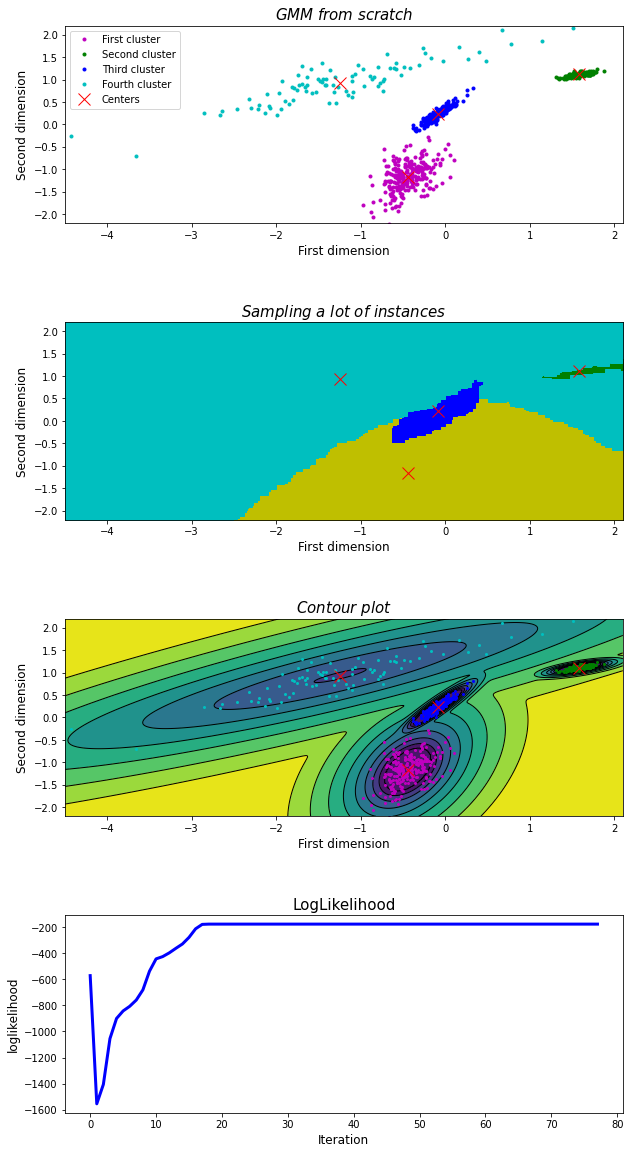

In [20]:
# First two plots are as_before
plt.figure(figsize=(10,20))
plt.subplots_adjust(wspace=.5,hspace=.5)
plt.subplot(411)
hard_cl=hard_clustering(get_responsibilities)
plt.plot(dataset[:,0][hard_cl==0],dataset[:,1][hard_cl==0],"m.",label="First cluster")
plt.plot(dataset[:,0][hard_cl==1],dataset[:,1][hard_cl==1],"g.",label="Second cluster")
plt.plot(dataset[:,0][hard_cl==2],dataset[:,1][hard_cl==2],"b.",label="Third cluster")
plt.plot(dataset[:,0][hard_cl==3],dataset[:,1][hard_cl==3],"c.",label="Fourth cluster")
for ind,item in enumerate(get_means):
  if ind==len(get_means)-1:
    plt.plot(item[0],item[1],"rx",markersize=12,label="Centers")
  else:
    plt.plot(item[0],item[1],"rx",markersize=12)
plt.title("$GMM$ $from$ $scratch$",fontsize=15)
plt.xlabel("First dimension",fontsize=12)
plt.ylabel("Second dimension",fontsize=12)
plt.legend(loc="upper left")
plt.axis([x_min,x_max,y_min,y_max])

np.random.seed(17)
data=sample_generator()
test_responsibilities=scratch_gmm.predict(data)
preds=hard_clustering(test_responsibilities)
plt.subplot(412)
plt.plot(data[:,0][preds==0],data[:,1][preds==0],"ys",markersize=12)
plt.plot(data[:,0][preds==1],data[:,1][preds==1],"gs",markersize=12)
plt.plot(data[:,0][preds==2],data[:,1][preds==2],"bs",markersize=12)
plt.plot(data[:,0][preds==3],data[:,1][preds==3],"cs",markersize=12)
for item in mus:
    plt.plot(item[0],item[1],"rx",markersize=12)

plt.title("$Sampling$ $a$ $lot$ $of$ $instances$",fontsize=15)
plt.xlabel("First dimension",fontsize=12)
plt.ylabel("Second dimension",fontsize=12)
plt.axis([x_min,x_max,y_min,y_max])

# Contour plot
plt.subplot(413)
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),np.linspace(y_min, y_max, 500))
Z = -scratch_gmm.log_probas(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
Z=np.clip(Z,a_min=1,a_max=40)
plt.contourf(xx, yy, Z,norm=LogNorm(vmin=1, vmax=40.0),levels=np.logspace(0, 2, 12))
plt.contour(xx, yy, Z,norm=LogNorm(vmin=1, vmax=40.0),levels=np.logspace(0, 2, 12),linewidths=1, colors='k')
hard_cl=hard_clustering(get_responsibilities)
plt.plot(dataset[:,0][hard_cl==0],dataset[:,1][hard_cl==0],"m.",markersize=4,label="First cluster")
plt.plot(dataset[:,0][hard_cl==1],dataset[:,1][hard_cl==1],"g.",markersize=4,label="Second cluster")
plt.plot(dataset[:,0][hard_cl==2],dataset[:,1][hard_cl==2],"b.",markersize=4,label="Third cluster")
plt.plot(dataset[:,0][hard_cl==3],dataset[:,1][hard_cl==3],"c.",markersize=4,label="Fourth cluster")
for ind,item in enumerate(get_means):
  if ind==len(get_means)-1:
    plt.plot(item[0],item[1],"rx",markersize=12,label="Center")
  else:
    plt.plot(item[0],item[1],"rx",markersize=12)
plt.title("$Contour$ $plot$",fontsize=15)
plt.xlabel("First dimension",fontsize=12)
plt.ylabel("Second dimension",fontsize=12)
plt.axis([x_min,x_max,y_min,y_max])

# LogLikelihood
plt.subplot(414)
plt.plot(get_likelihood,"b",linewidth=3)
plt.title("LogLikelihood",fontsize=15)
plt.xlabel("Iteration",fontsize=12)
plt.ylabel("loglikelihood",fontsize=12)




Now we use the sklearn GMM class in order to analyze a cool image. In this case we don't use the class created from scrach because it's very slow.

(-0.5, 259.5, 193.5, -0.5)

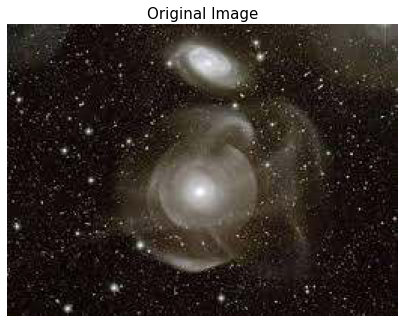

In [43]:
imshape=100
def crop_img(arr):
  return arr[:,30:arr.shape[1]-30]
req=request.urlopen("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAwICRYVExgWFhcZGRgNDR4NDQ0NDSUPEA0eLCcuLisnKyoxNzo7MTQ2NCorMUc+Njw+QkNCLztKUElATzpBQj8BDQ4ODQ4PGA0NGD8mHyY/Pz8/Pz8/Pz8/Pz8/Pz8/Pz8/Pz8/Pz8/Pz8/Pz8/Pz8/Pz8/Pz8/Pz8/Pz8/Pz8/P//AABEIAMIBBAMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAACAwABBAUGB//EAEEQAAECBAMEBwYFAgUFAQEAAAECEQADEiEiMUEEMlFhE0JScYGR8AVicqGxwSOCotHxkuEGM7LC4hQVQ3PSgxb/xAAXAQEBAQEAAAAAAAAAAAAAAAAAAQID/8QAGBEBAQEBAQAAAAAAAAAAAAAAAAERMSH/2gAMAwEAAhEDEQA/APAJqYs7JTi7sjfxg5Et/wCqIB6+kNSQBwy4VW+cZoaUlNlAgp6qsKuIt4wKi97fDC1Ke7vV3wVJABviTUlSVaO2mXdFUCkh3dIw89POMm1TKiouT1lYfJ2ytD588JSQAxU6VKq3g2TGw1DiMakHEAQqjrJeluN2OZGkFgQOLt9tWhnSKSmlwysWFsrWPkPGAPh/VV6ziBNvWXKCoRDihSCpBcKpCaZagpKgbs7tl337oU7lmbq8INSwAU0pxNi6yWvbv1tpAHKvwFWJPV72OnKItiokAAVYUpSMI5gMPIM8ATbMtuq+9vCCQAH1w9bz18Iget1Fyd1I3cGQd2YZZcTo8CZYHf8A06P4RFJudRenw740y5VQFt1JxdZRJdzxjITLlO9i1OLxhsuR1gA6XUqpOFQZvubR0ti9mFV46X/Y1NhH0ga8oqSRbvqgaS2v9o9DtXsZac0kfljl7RshD2gMSklJLgP/AFZjRraxEAPfK1Sk4s+HGDMts/y4d6BYu+vagCmBLmhylOFClSwhSuZDlvOKYNn7u6cvJjHW9kbNImIWJilBaZP4CZbKqJNgeGccogVcqvlAWBl+nz1ggogZt7tXJvoYWdeFv7P5GBf9UBpE0psLe9Ue7uhwUSkYrdmqqnv4ZRmIICcQxJqpS/4ZBa7252ezQ2WoE3fe3utAPSk53aqmrq+mhqYzpVoL+9TwyhwPH9UAai0HLWxELqFNwHqGKrd421gSoCw/qVwB+UEdFKiLg3jQva1FID2v9BHIRNIAuMWLeGHv4Qw7RYcb/aKY1VRIwzFEFlWOotEi6OXXnl2vKDQpwXhC1Us4IKsWJ8T3BHhFGaz3/TVVwbhAjRUGNr1YVVbo1tztd/rAKmgC7YsPveHiOMZ1zYtO0EP76QleEKqDgjMWuBlCBS1P/wAoOUEVgKUqi+JKQlfkbfOIFMwDHEJiU9GFVHgeN9MuGcApSlEm2qqU4Up1sOUVYOpICglNQVLCekWnFLLhyGNnZr6GASq94ds09SakC6ZqaZqd2oC+f7ZwKJK1KsCpSqt11ZBy3G14BaUu/u+9E+UW6SD2t5PvcuWp+UNUpHRpASa6lKmTFTBSoHIAcrvADW/PCE/DfQRAWFhvevnC6tINiCD+pScLC3ceEQaJdINv1YVcraPHa2KQFdyetHCVOqUpbJFSqqZaQhCX0A0j0Oxe2kJ2foqE1dIFdKlJqyyeIOzImJSQlOXaUmPVbAhKUghLlSaqo8MNorZSc0pxdXKPUf4f9qpICVHdiyxmuvM2YLDKH5qao4ntT2Ck8qt1Ueslz0gWAIVGSYoGziN3EfLvaXshUskERy5km/D3d6nkY+j+25SCBk9VKe6PGe0NmFRs0crMalYvZuxpmzUIqprwzKt1s/rDvbmwI2eYqWlQWaqumTMNLPkBq7i/7xknqpYixt1vnbKMu0qVVUo3ViSqqrXjEirWuzO6U7qeySbt5QBBfIurDi4gs3nFy5pSxFqcVSXSrhn4wAybOr0AI1gIKZrcVa8LQxCrwgrext7ynqTZr/LSGEXbKndwnENC37xMGurjn6aHzNpUqkKL9HLEuX7oGQtzMYZagbfq6vjGgy1gBSkkJmJKkKUmlMxixY6sYBhMCpV4IqDBiThxVYaSeHyvCwqJoNCgM33T9Ld1/lEUde1iw7t4oEsW6yafiGbHyEUlIa/rw+8VMa5KlKSL2ThGEd/3iQir1TFQMcbpSlxkVJCVJp3hrnxYGLVLYhJcKq6+BPi+XjDf+m/BEytFSp3Rpkf+VmzZmABDXjMrP9MbIMkFNgaqipVKhQ3d6DRKjb3cSaeqc/CBSdCTr1vXCLGY+LFSrX7QBpTU+W9TvMq/Lhr/ADCwRrf1x0i1PhfrJqTi04/KKN+X94KiVEZQVSnzL73ZpOvdpBJSwcgGp0pUpQpyINvEM8LeAsm9g/uqveNClPKCaAKJyqpnR4rjInk3CMxS/cne9c4u2R6r4kq10zygIC2nr7w2qzZ9WpL5ahmgBdwHeydMs/q0WBl7v6eMQEBYqPapV2rj+2cX0jMXurs4e59Iocb4d6lWuhbvP1gVqUo3uVKqV1qic/nAdTYdsKc3aqmqk4TweOpL2kpNST70eXNQtfDvJ7Jdso0SZqkjMkUjzza/cbiM2D3ns7/ERACVGOh/3SrIiPncva9f1eOsaZftBQyMNsTHsNomlVyY43tFITc5qT0nxA6/WOd/3dY4H4sUKE+bR0yQulEwS+mTupUA4Bb5PEt0xn2oi57W9l32JjGmaQeadxVW7fTTlDzPYGweZLMvdCqRqQO4EacRlGUB3De8nFuhrtpFiolklJUkKF1dGpW8OZBcRSmBIBcX92rgWPgYOWU1prCiioVplqpUoDgS7eULvpFDZG0GWsLSlCjSf85NaUkhnY2to/lA1KmGpRJPWmKdSld514QtIa+v7fzDZS0pVURXSoKTLVZExswWv5RQ+elCZhShYUlKglM6WkpTM5sbi7+MV0pLDROJPWp/aB2naVTZlayl1qGFMuhEsCwDAMAGFhpxMAV3JDgqxYXpY6c/GJg0CbYD138oclVNYWkVdGKUzEnViCGtkXvGETj/AFYlKp19DSLlzmA+Lkr5G3nEwbAq2uH9R+giKzYdZWGpWhyBPjGY7QaWIsl/T5wJnlh7v9XHxhg03iQ/ZNo2en8YTCsqJqRNCA3c0SGI5ns3aKJyFqQFiUrpJkuZuqAuX4/WK9obQJs1SwhKAp1JlpwoSHJYfSEJSSLDhi9Zd8O2mdUyUoCPw0pVLlbsw8W5lsuEbVnAcsB+XegkrYKANpjVJ7TXD8LxdICXbdVTVVSXzuLnlp5w6bISiWkuqua6iKbISC3nZ82bnAKVKKSQoFJSylJVvXyLdxi5M9SCaWxS1S1VJCsJFwxf+0UCG57tN8PPxhu07OqWoBSUuqWman8QLwnLXmLZwF7ds6JZCUTEzDT+KuU9CS5sCQHsxyzhEmWVKCUgkqelKeQd/Bn7oomLVLYA6K/dvtAGFgEilO6U43XTZnDcw40ECiYwLOFK3lJV1dQ3zzhRuYM2z/L3QBpUzs27SrrVOX1yy9PBywOI+afHlyhQU+Z3UhKe7QQUoocFdRFQrTL6ydWOkQWu5JuEqUaat62hOuYeBBu4+2l4dLT0k0dIunpFfiTlJJsRmwuXbQfvBy5TEGw6yafv4w0AmTVdxiVixeTC2Y9CIJJOX+mmNktI8Y1Sw2TCM6OanZ1aflhidnWHJpOEqThqvoLM0dcSndwN34fKGS9mBijmey/Zqps1MupKa1U1TFUpTzJ0he2bMuWtcupxVi6NWGY2T8Y9AnYDmLfmjFt2wKDku/vKqyiWJrhiX3fKHGUEkMQfwxV1aX0PcGy1glAs7MKqaubO0UZuEjVTYqQpTDO+fruiao0yRThNkpHSYQmkksANTkPWa5uyEuoAHPdw56+EHKVe44/3HjGpMwF3IFMsU4SrpCAzcn8oQcYpIJB62H+8CioFxnLZWml/rHXnSkrxAW7PWy4ho5RSQcr1YU01ZDhG9EWTmbleLdp8WHefrD5ZQoms00oUtKpcnFOVwPB+OnC8Zkvm30gkra2YqqxPh7vN4oFy40FlYfr94j2uQBVyq8vCGy0pWtlKCAr/AMlJUmX4C5yAt3wkKtl73rjEEUSc84gPD4aflEY3z3YbMlhKxiQsYVK6B8OrOQLjKzh+ME1o2b2fMWmpAls7GqehBfuMSMk5qiwAAJZKkCYoB3DluESAQ9vWKCcuFJw0tTSo1JIGb/Pl4RGHHrDq4mPD9opwHbKrDhu38RVGJjkFV6Ww7tQF2JHjneI5YWtVVVfFyfLhAlJvY4eziiLsWP6WUnjmDAFMABDFwpIUrDTSeDPFEEZ9mpOJ84taSlTMHT2VVJ4u4hYVppAdbZPZS9pmTOhQKZUszaEqJEoAOwe9srxz1yylSkKLUqKV4sPyzyg5G2LQ9ClAqSUqVV/mDTOFLvzUpWLP+IIuSQFBVzSsKwpFSmvZ3Gmr9xygZhSVEgMmo0pViUkaBw2QbQRRQQz2qT0icQy+2XfDJaalAMwUqlPuufnBQM//ABxJ+VoZLTkeyyt0U24jI5eMa/afs0SZlAWlYpH4snEh2dgbcYFM0IQpBQlRmKH4isSpbG4BBa+tomgJs0rW5CQVMlKU4ESxwAJsA/cIYD4mo1ZU25jOM5Llx+lO73QyWOBL1YcPrlpGRqlExqQkgD3v3vCA5ItSKRTLSoqp45ubm8apafKMhqHdh6746EtQGcY5aW1gZi7s8XRvPtAjJo07LtQmAhQBHvKHd944RmnLT1eGbPOILwlMK9t7H0c6pADLSfy89YwykmWtljhXLVhqBuAdbhjHU9qqK0VaJV0em8zs2eQzjjKUDyw/FUQPk7ARRp22aFrKkIEtFRplpdVLmwc5+MHISSknSnEreS54HTIwiWpwoEqFSk7uJCgON+5s/CNkuXh5JjIFEpYSpbYUtUpTJpc2YZlyCLfKMW2yXFX+7eMPnKy43+cWoYSlr+89SbZfP6RqDkpGIAlh1lU1UjUt/EAD68P3h07gw3qqr1ZZO/owtJ3rPh7O7zjQoZC4dT4bpp4XyiKU4AJP4aaUp7N3I8zDkKASymWChSUy+kKegUSwPyfV9eEISAVaNVvdVMUWpUEFUl+0mnEnjmWgFgAliCKjivi5h+MVVrBF+t2JFBPoxImGC6QO9KRiq3TSrwya4yhZNgLt8WvGDEskKKbhG9lk7A97kZQNPHrJqTT64xVGFtUDerep+RB8fGKBSyrF6sCqt0d2totSqgHJKkppxNTSL/K/rNZVAdX2KnZiV/8AUFQplK6Lo1DEprODzzjEiWVEoSl+lmBMpKkmt8mGgfV4TzS4pxft84tSllyokmrpFdIomo8S/fBFB0l7ulR/KRaKKSMwcWJNPODUQonMmoqVMUwq1dtM+MDUbgGylBVOV8vvBVEMcv8Ab64RrkbStlpqVRNUlU/L8Ri4ucrktGMi7GNMsDR295W8w4ecSg1KJBxGmqpMtSvAFsjbODlzUhC0lCVFaUpTOU6VSQC5Yc8jyilKdrXSreti7/IQIRw9cf4jNoiEngD7qk1eekbdnkUhznanFu8PKC2LZXxN65R0JezORw97DEtGVMon/wCv7xqkyzlfsxr2fZnyjZL2ZIuYYObMTbn/AGjMEkm8dpckE2vAHZmhgTJkpUKVC3+mMu27GZd03T2lNUnv4x1AgDugJpcNmIYPPT9DU5pCt0pUkvxOeQNvtCFJKmDAUvXMS6lKc2fPIkANGvapBSttLpT3GNGzbChSFrK0pMtlJl3T0hJyAbSEWsOzyOJt2bx0CsJACRanElWKo/a8Zwry6ucAtds4qM05RIs+HD7r98FsygbB8W6moJpt68IAbOpdTMKZapiukUEJYByATmcucXLUgKUQpTU4FKapR1fhrACNkEwLJWhHRS+kSmYqnpL5DnflHOMuxPZ3k8uJ8xGqeWJe2I1J58IyLU6iSd5WKLEw1GzlSVrBQBKZSk9IAtTlhSDc3zbLOFzZqlEkqJqSE1cgGGXAARSQC+QpTViVTUxytrFLYgXU9RqUpqeTa8XjSruMy2aVJ3VWzBEQsSwtn9eMNKVSwDSxVLExCqhulw5AfPmxHjCSq5c36tKRm/7PAUxFvooRInhEgglpYJGHd6SpOJV9C3BvCBlpKiBc4t2rziiHNh/S/jBKN7pb3ezxgqUmlx1VbyfVvHPwMA2np4YVAswbCEq61V8/pFygAQoKppUnFvLlm1wzd9rwCwojh2tOHGLIAIYhWHs8Rkx4QU0JFkkqq3VVb3NufB7HUwJSRmCMqaoBux7MuatCEAqWtWFPaPKC2jZVS1KQsFKpb1pslSdMi3y8oXs09ctaVoJSpOJKk4fF4ubPUtRWvEpb4lKOZ1d/rALTc3/pTG/Z6aWZ6lDFfC2YGl7aRhSPLtRvQkNn+mM0QofIEBO8q+EHiYbKlPb14xYlFvXrWN2xShWL7voxmjfK2YJSA0MEvIQ0GpXJKd3swaAQqKNMiU1hG+XsbjKA2KW5j0Ox7HWwEak1LXnJ3s8i4jPS0ev23YaLGOBtsgBRaFhrkLSx5Qro4fOIEZ5k2MVWT2mgBIUPzRz0rNy7FOKr9vtG/bS8tQjmBbA/0/OJVMmqTo4NIwzMV9WtbSFKuL9nrPhEUC5L59qnhy8oYhweBpp9fONIyoCySE1EVUqpUaXVa92D5XjPLGt+1/EOnKLAE2Srd7+6+kZCb3iQO9oTEFQKAU/hitKlBWJrs2XdGIkX4xoIdwE1FSasL4WOg5gEXeEqUwKWsqZUqpIrsGzzGeUbgk5ACUMpKq0mZSl6pd2ZThnYA2eFFNvPhpBoS5awwlSa8Kcic+enOGbKQlRVUkUSzMRVL6VKlM1J73zNgYoUg2yDVdZIUp28/tFEcezh97gIgzYNiUE1K+rnJ4i0tr8SaqrwFAj+P4iRRbV39cokTEMaxVUBip6OopWzO7DTTyigDYsT1sT+fjAQVR5+svpFU6VIUualCSKpqujTUoJS50fLxhctbA5YuspNSk930OUCotwPa60WBZ3HZpqxZcPvAAYJK2awwqqxdbv4wSZQpKitIpVSmXdS1cwMtdTFyUPqHS2GpqnLWPlk9nOhgCutRUrJTqV0akoSklz4XD5ZcIUtLEe8kKT4+v4hoAKSokvVjlpSU+JLMHvAFLgEJbDi61V8+WYgKlkAvnGyXp8O9VV5tlraMoRf/T1Y1SExmjTLXG3ZZ1z8MYQmNEoMR736XyjKuvsW0CsP1nTG0qvHDDpU4O6rD+8diUoLSFD80IjqbFPAMeh2Tbqbgx5CWopN40y9vKY1LiY9RtW3FVyY4e2T7vGc+0H1jFP2h4umA2mbGRarwxYLE9mM6hztGKpG2zMBF4wGUQWVapIVvDC+T8PG41jZtpAwkghL4kqw2sIxFYFvSucRo0Bi2ElMw4k9bTPXKGhIJACTiTup6zC7HwMYjNy9ecM6RTPcVJpqSo4gbHzvFRk2lTm2VWHrK5RmBjRMURfs4vXlGZaiXyA7KVfLjpFiLWrMMPzYld4hDXgyq2kDU5y3f31840IcnILbqe8esopRN9e1EVnBTVpISAikpTStVRV0inN2OWYFuD6xQBa3G9WVPJohAAFxiTVSnq6X+sRGdv6lRZGnZ3vO0AESDSUtep/dZvpEgjp+wvZp2hakJUlJ6JSvxGZTB2uzO2YuPGME9FKlDsulNKvKBRNKS4LGkpqqPjFTQAXd6veClPzIgKfnuurF1uUWFWLE4sKk+L/YRQ0Nuz/f15RTEObb1NNqrh8vQgonB/2/xFPkXLqxRa0kOWPu4SlKT4/KNns/aEIn1zkKWm/4aVdCpxYFxkxbSAzyEoUVFa1I6yaZdaVciXB+R5xJZYC/5erl/eCARUCUmmrElKhUod928RDkrSEUlKDSqqqklarCxPh3O/GIIAUFgUmqWKlS2WliAQAfC/A2jTKCSkFzVViTSEopbjnnyjFOmgFk5VGmnCnwdjyvFS9pa9/eqxZnSM4OtMWGFr3+sRM05B23sO6+kZ5G0haWYA1YVKepm8h9YqYpSS3Z7+MBvQ6hZnSkqUlLYQMyYbsm1mWX06yVfWOSZig2YzViw1Pr6MOlh7lQBthqqUp+DcNXiNPTI2hExgk3V1e/IQsrGWscJaaDZQUFbqkviHcbjxhsuaeMNTHYCwdRCzOSH404cOscwzykv/xh81bpqFxuw0wyZtFucZJ+0Efm3U9qFTF/6aoXPSmpwoqTSN6WUVE5jUBjq/OIuM0xZJJf4k8+F+ECqaQ4BNKmUpN6VEDXuJMSkkE3ZLVUp8A9mDxQmJpKSHP/AI5l/wAMvk2RBd8ieEWBRX6vrGnZ5gNu74fTxlYaXw1K6tOnjByxcX6wT2U/2i3iHbRLUCQQR8WHPj4RhMdTaCVJCrOntdZsu/hHLX6qhAIzaAWOH/160hyEjUgdbE+IDhxv6tC1KFRLDE+HRL8ByjaBPf1YsXs/6aoko3Z2CsKsstWiwBYZlRG69SdCOb2ygJ0ZDOwrelVXDnFzaHZBURSlSulSEmprgM+uXKKDWccMVT08bc3gVDT+ykwGjatoVNKa6XlSUyE0oSmwy0iQOE3JIJ3khDB+QGUSCegROWFBTuUptUkEcMvlFGzkCyt3LLn5RAkkvYVe6Kb3sIJQD2BHu1Vd97QUIR1aSSpqO08RUtSSQQX6yVJKVJ7wYgWRl1fX3hiZu8SKq0ql6hMsnUEebZQECSULUpR6qcSgqrg99G4HwgARrmrF0irJ52haixcflyVDZZpxM+SsV78fGAAFRsBdTU9qLCndz1cMAtRLk5qUVKV2jnBhICQoFlVbvLj4Hjx5QAzCcz6EHOlLQulSaVJapHzuIW/h2sW8YYZmEpKQSpQVUq6k9x56wG72NPly5qFrDpTM/wAvk3GO97TnS9r2hX/TopCZZmU1DIBybtoCY8kwuRlVh7vly4d0NG0EWu3V89DnyiYmOjNkmxzw4s1fxoLRQkkegq44QOy7cGIL4espPh36iOzshlzLBozY1rnS1sgpKUmpQmJmKepLC4HfERl6wx2z7IfIxlX7JUk5/wC6JZYayTptSUuB+Eno8KaVKDu545mAROKQXyU0axsKu+An7Awc2+JQgMk5OojOtbc/WcNXtCUggYusqnqjjCZkwEZXV1uqxHAjxiGlqUAr4e5WXyN4WqZhIYYlBVVIqS1mB07u6KJtYjdKt6rl4QBBA5/2/mNSIgVmGar80GmzEwARch7J3Vdru11iD17vdwjWDYFFiPd+JMY5mZ0EPFgz/m6sJSFFQpFSlYUppCsw2Rtr99IBakhgXGLqpViToXHP55wttIsJOel6qnSlTaeMElJUohKbzFGlKVHvt/eKLoDOAWSopVO3qnFraef0gCt8hSLYd5OWbnjnDJagcPVviUrCkMwcXFjrxhBBBb+rwgIFEXDilVVSbKTwvnBBbhmGuKn5+DRAAbEgYTup3jw+0A/6YYJMN8msLRIJSb8ORiQDdpwrIHVVThVVcWJBu9wTnCUli+v9UQ97+9yGUFKRVZxulWJTXHfx+cBAAzv1qaeTZ8PDOADf8oMgO1yPcdVR+XdFMAb3qT6z5wAkPfs/vFqmE96t73r8ItIGuemeGKSl3NsG9iCeWsEUTrlF1ZB4s5fE2H7xEpGpbDUnDVVfL65wVDmD2W/Lw+kGUgh3c1GpNJClDj4x0PYXsZe1zQiXvbyoVt3s1cmoLKXlzOip6THk7gZtp3wTWJv+WHnpDCA4pc4RhmNU4t65QCiL2I7Kez53iEgAWvf4Vd3rygqiq+fu9mGS5pQxSS6fdw5wCDp+myfLzgjLP5qujSmrEk5XHOA7Un/EC5TAmrClSsJTTq1+HLONn/8AUo1QSafijzEwEqNRCT2VP3c++BUACQ7gKKak9bmAePO8TB353+JFmoITRSk4qQpVu/K7DlzjlbTti5hqUpR6utD8neMoyLFs002TUPWcGC+FJWylVdGnHds2tf7QwMRPUlKkgsJmFausocC2h15twghMUpqlKbdTmqm+nmbRnAtmO1vfYw4SjQTYppqw9U6PrmWigkKyuN7q4vGGIDk6CM96s2yUlV01fQ8TDJihchRNSlYeyHseb31e0QQpFsv9MQm8CpSmzfq1VDThAVXGkBoJOjmM6iXeHbLJXNWlCGrmKpTUoITfiSwEJVKNBW4ZMwS6ekFbkE5Z6X4ZQFIBNrbuFKuPLvi1WSz3UqlUvo8SWuL95OV+MUpKgB/TvDC3d3iBSnKzjs7tQ9WeKLJAO77qkqU6e/73ygONrH3tOHzEUTnmPWsWVcT1f4BgJNWVLKlZqVipSE/IfaIhRSoEWKVVJyq4xSklLggg9ZKk0qSftFlWFjc1VVVboyZsoCl55RIqqJAXYcD6v3RASLi3lEKgzAdaqqztwiEE9yYC3IIKSQd5JTvJ4FxESkEXU2HDUl6j4feBBgq7M3VxcFcLaWggpspUvCpKkqsqmYmmxFix4/SFn1/eOj7ObaJ8tE+YQm0vpJiqilOgflDf8S7JKlTqJKq0JeqZVvHuOUBycrdl/Tw9CUqUkIcYcXSKCkuzqItlwFz4wgJ481fFFvYj838wGzYNsXJWFoWQU7yU4VNqPlCdq2tU1VSzUqmnpOswydrWhKRYv1YgLtmad2CiTndyOtTvNr8oJR0BLVVJTVV3OONoFAKiwBJVhSlKd7kBmYJIILEXTiUldjY5erwAFwYKVNZaVlyUzBMV7zF8+fjBJNQY1UpUZiqVYU8SAf5gAhyAxdX8j94C5hBJITSlSqqUqqp0ZzeBUO9/ebLjF1OP930gkrCVOGV/7JYUFOGyPC/jAAMrjji7tOEdb2D7L/6iYtImJR0ctSkqVMo00jkkHhBSllLlJbNPy/uYA5ySlRFjiKUqpFKmiLJdm3XxUlPpoi5tgEgDDiVmpWtz4WZjBhSVrxrLKUFKmKSZqnIued89W45QQp9Dkl1dmr97xRUWinf1V6vFu4A1v+a756wVH/VBSSKkhSqU9JiVTVTo7a5fKKM9akpSVEplpNEtSsMsEuQHych7QILO1+rUl/GAfss1UualYSlRRMCky5iakTGORBzygJ82olTNXMKlJSmlD5sODOYgUbKSqko7OEpyD6O76PaFggBiPhxHDz4QFpUAoEpBFX+WpRCVciQxiGW2oOEKwqHkeHcYH1VBuHu5CWqTVito92gJtEsoUUqIJThVSoLTbgQSDC2YiwPaTfy0+UOEt6ikOmW2+oJp0Hz4GEj/AG1fuYAlIs+lkq6tKs2+UU7ODlvaesosKwkMN4Kq62WTxZVwypCcTcL5QC25/WJBKDkkWBO7W7RIagDD1/5afiKfB4kSJFKGY+FX0ijp8IiRItFnMxczNXxK+sSJBBH/AC/y/wC4wtGY+IRIkBcreR8Y+sHNsVNZphZrNEiQKFCiCCCxCwQQWIiio3L3pze+cVEgqzl+b7RD68okSAuZvHwgl5H4YkSApe8fWkRHW/8AX+0SJADofi+8WqJEgJM3j4QU3e//ADT9BEiQA6+UWvI/F94uJALg9B8P3i4kBJWfn9DFHP1wiRICS8x8KvpG5KB0U2wtJltbLFFxIDArMRRz8okSAoRcSJAf/9k=")
orig_img=imread(req)
img=tfimg.resize(crop_img(orig_img)/255.,[imshape,imshape])
img=cv2.cvtColor(img.numpy(), cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(7,7))
plt.imshow(orig_img,"gray")
plt.title("Original Image",fontsize=15)
plt.axis('off')

This is a grayscale image, and it has been normalized such that each pixel is in range [0,1].
The image represents two elliptical galaxies, so if we run our Gaussian Mixture
Model with two components using each pixel (flattened) as instance, it will assign bright pixels belonging to the first galaxy to one cluster and bright pixels belonging to the second galaxy to the other cluster right?
Wrong!!! Since we are working pixel-wise, each pixel value can be interpreted ad the probability that the pixel is white (which is the case if values are close to one).
If we run the GMM with two cluster, it's likely that the algorithm will put brighter pixels and darker pixels into two distinct clusters; so we can use it to binarize the image.

(-0.5, 99.5, 99.5, -0.5)

<Figure size 720x720 with 0 Axes>

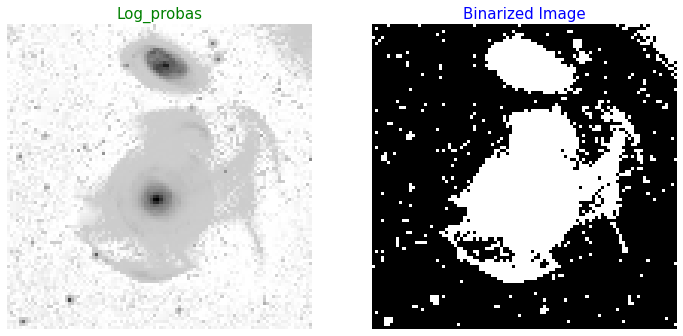

In [44]:
flatten_pixels=np.reshape(img,(-1,1))
gaux=GaussianMixture(n_components=2)
gaux.fit(flatten_pixels)
preds=gaux.predict(flatten_pixels)
log_probas=gaux.score_samples(flatten_pixels)
plt.figure(figsize=(10,10))
new=log_probas.reshape(100,100)
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(new,"gray")
plt.title("Log_probas",fontsize=15,color="g")
plt.axis("off")
plt.subplot(122)
# Binarize the image
preds=preds.reshape(100,100)
plt.imshow(preds,cmap="gray")
plt.title("Binarized Image",fontsize=15,color="b")
plt.axis("off")
